## Leitura e tratamento dos dados

### Importação de Bibliotecas

In [1]:
import pandas as pd
import gdown
import os
import matplotlib.pyplot as plt
import seaborn as sns

path_dados_vinho = "../../dados/vinho/"
path_dados_genericos = "../../dados/genericos/"

In [2]:
# Definindo que o float terá apenas 2 casas decimais

pd.options.display.float_format = "{:.2f}".format

### Exportação

In [3]:
df_exp_espumantes = pd.read_csv(f"{path_dados_vinho}ExpEspumantes.csv", sep=";")
df_exp_vinho = pd.read_csv(f"{path_dados_vinho}ExpVinho.csv", sep=";")

# Derretendo o DataFrame de Exportação de vinhos para ter uma linha para cada ano
df_exp_vinho_melted = pd.melt(df_exp_vinho, id_vars=['Id', 'País'], var_name='Ano_Metrica', value_name='Valor')

# Separando o Ano e a Métrica (Quantidade_kg ou Valor_Us) em colunas separadas
df_exp_vinho_melted[['Ano', 'Metrica']] = df_exp_vinho_melted['Ano_Metrica'].str.extract('(\d+)(\.\d+)?')

# Criando um DataFrame separado para Quantidade_kg e Valor_Us
df_quantidade_exp = df_exp_vinho_melted[df_exp_vinho_melted['Metrica'].isna()].drop(columns='Metrica').rename(columns={'Valor': 'Quantidade_kg'})
df_valor_exp = df_exp_vinho_melted[df_exp_vinho_melted['Metrica'].notna()].drop(columns='Metrica').rename(columns={'Valor': 'Valor_us'})

# Mesclando os DataFrames de Quantidade_kg e Valor_Us com base no Id, País e Ano
df_exp_vinhos_final = pd.merge(df_quantidade_exp, df_valor_exp, on=['Id', 'País', 'Ano'])

# Reordenando/Renomeando as colunas
df_exp_vinhos_final = df_exp_vinhos_final[['Id', 'País', 'Ano', 'Quantidade_kg', 'Valor_us']]

# Filtrando apenas os últimos 15 anos
df_exp_vinhos_final['Ano'] = df_exp_vinhos_final['Ano'].astype(int)
df_exp_vinhos_final_ultimos_quinze_anos = df_exp_vinhos_final.query('Ano >= 2008')

# Função para identificar os 10 principais países por métrica
def filter_top_10(df, metric):
    top_10_countries = df.groupby('País')[metric].sum().nlargest(10, 'all').index
    return df[df['País'].isin(top_10_countries)]

# Filtrando para os 10 principais países para cada métrica
df_top_10_quantidade_exp = filter_top_10(df_exp_vinhos_final_ultimos_quinze_anos, 'Quantidade_kg')
df_top_10_valor_exp = filter_top_10(df_exp_vinhos_final_ultimos_quinze_anos, 'Valor_us')

# Lista de 10 países que mais exportam + Brasil
lista_top10_exportadores = df_top_10_quantidade_exp['País'].unique().tolist()
lista_top10_exportadores.append('Brasil')

# Alterando de KG para Litros o texto da coluna e calculando o valor/litro
df_exp_vinhos_final_ultimos_quinze_anos.rename(columns = {'Quantidade_kg':'Quantidade_l'}, inplace = True)
df_exp_vinhos_final_ultimos_quinze_anos['Valor/litro'] = df_exp_vinhos_final_ultimos_quinze_anos['Valor_us']/df_exp_vinhos_final_ultimos_quinze_anos['Quantidade_l']

# Filtrando apenas os top10 + Brasil
df_top10_exp_valor_por_litro = df_exp_vinhos_final_ultimos_quinze_anos.query('País in @lista_top10_exportadores')

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\2181591808.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_top10_exp_valor_por_litro, x='País', y='Quantidade_l', ci=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


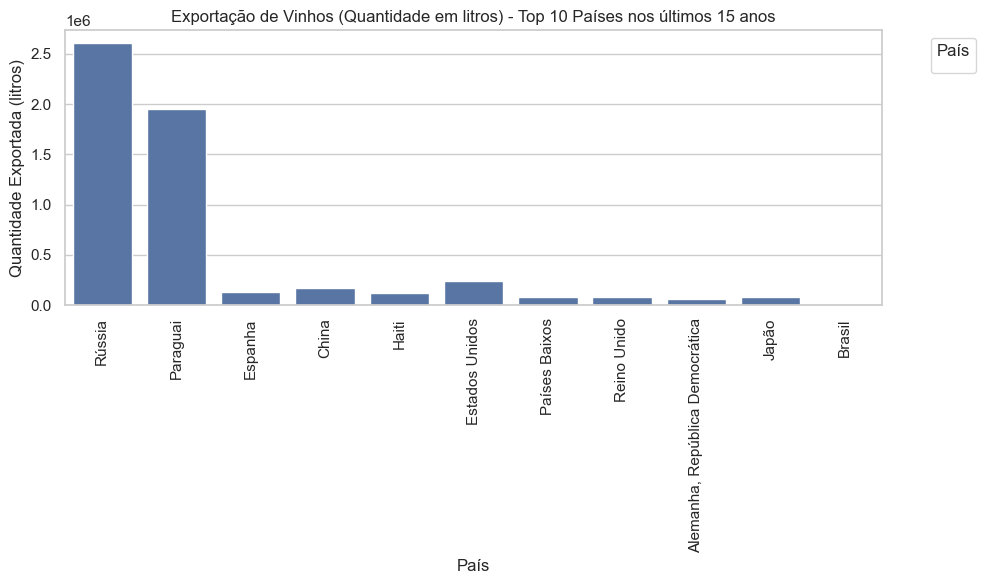

In [6]:
#Plotando um gráfico de barras com os maiores exportadores de vinho do mundo
df_top10_exp_valor_por_litro = df_top10_exp_valor_por_litro.sort_values('Quantidade_l', ascending=False)

sns.set_theme(style="whitegrid")

# Criando o gráfico para Quantidade_kg
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top10_exp_valor_por_litro, x='País', y='Quantidade_l', ci=None)
plt.title('Exportação de Vinhos (Quantidade em litros) - Top 10 Países nos últimos 15 anos')
plt.xlabel('País')
plt.ylabel('Quantidade Exportada (litros)')
plt.xticks(rotation=90)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

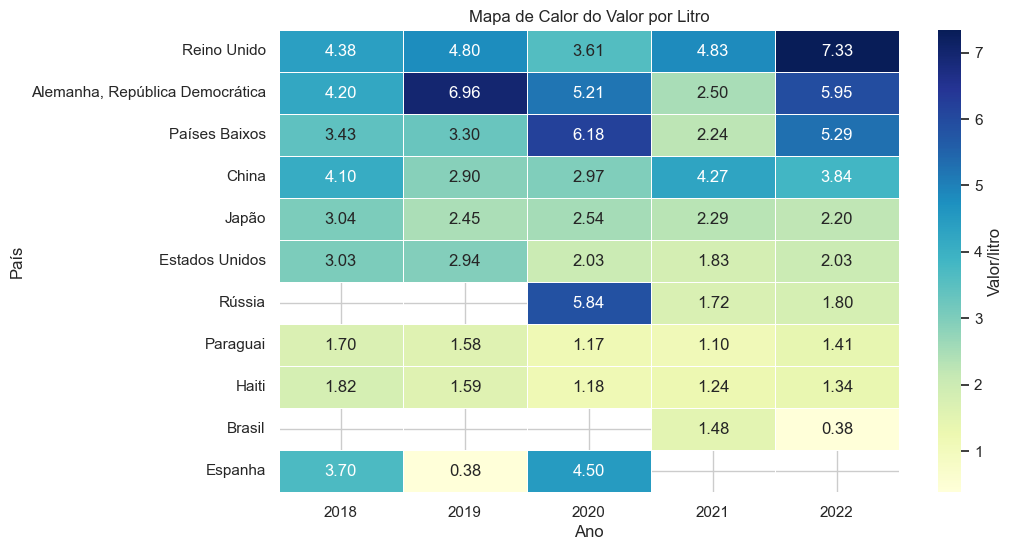

In [8]:
# Pivotando a tabela para criar gráfico de heatmap
df_top10_exp_valor_por_litro_pivot = df_top10_exp_valor_por_litro.pivot(index = 'País', columns= 'Ano', values='Valor/litro')

# Criando dataframe considerando apenas os últimos 5 anos
df_mapadecalor_export = df_top10_exp_valor_por_litro_pivot[df_top10_exp_valor_por_litro_pivot.columns[10:]].sort_values(2022, ascending = False)

# Criando mapa de calor p/ Valor por Litro dos últimos 5 anos top10 países com mais exportação em volume + Brasil

# Ajustando o tamanho da figura
plt.figure(figsize=(10, 6))

# Criando o heatmap
sns.heatmap(df_mapadecalor_export, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Valor/litro'})

# Adicionando título e rótulos aos eixos
plt.title('Mapa de Calor do Valor por Litro')
plt.xlabel('Ano')
plt.ylabel('País')

# Exibindo o gráfico
plt.show()


In [9]:
# Calculando a proporcao da representatividade de cada país na exportacao total

total_exportado_litros_ano = df_exp_vinhos_final_ultimos_quinze_anos.groupby('Ano')['Quantidade_l'].sum().reset_index()
total_exportado_litros_ano['País'] = 'Total'

df_exp_proporcao = df_exp_vinhos_final_ultimos_quinze_anos.merge(total_exportado_litros_ano, on='Ano', suffixes=('_pais', '_total'))
df_exp_proporcao['Proporção (%)'] = (df_exp_proporcao['Quantidade_l_pais'] / df_exp_proporcao['Quantidade_l_total']) * 100

#Selecionando e renomeando as colunas
df_exp_proporcao = df_exp_proporcao[['País_pais', 'Ano', 'Quantidade_l_pais', 'Quantidade_l_total', 'Proporção (%)']]
df_exp_proporcao.columns = ['País', 'Ano', 'Quantidade_pais', 'Quantidade_total', 'Proporção (%)']

#Selecionando apenas os top10 países
df_exp_top10_mais_brasil = df_exp_proporcao.query('País in @lista_top10_exportadores')


,País,Ano,Quantidade_pais,Quantidade_total,Proporção (%)
2,"Alemanha, República Democrática",2008,265742,10346323,2.57
20,Brasil,2008,0,10346323,0.00
28,China,2008,8689,10346323,0.08
47,Espanha,2008,2942,10346323,0.03
48,Estados Unidos,2008,443895,10346323,4.29
...,...,...,...,...,...
1867,Japão,2022,37324,7025983,0.53
1887,Países Baixos,2022,7034,7025983,0.10
1889,Paraguai,2022,5076670,7025983,72.26
1895,Reino Unido,2022,18835,7025983,0.27


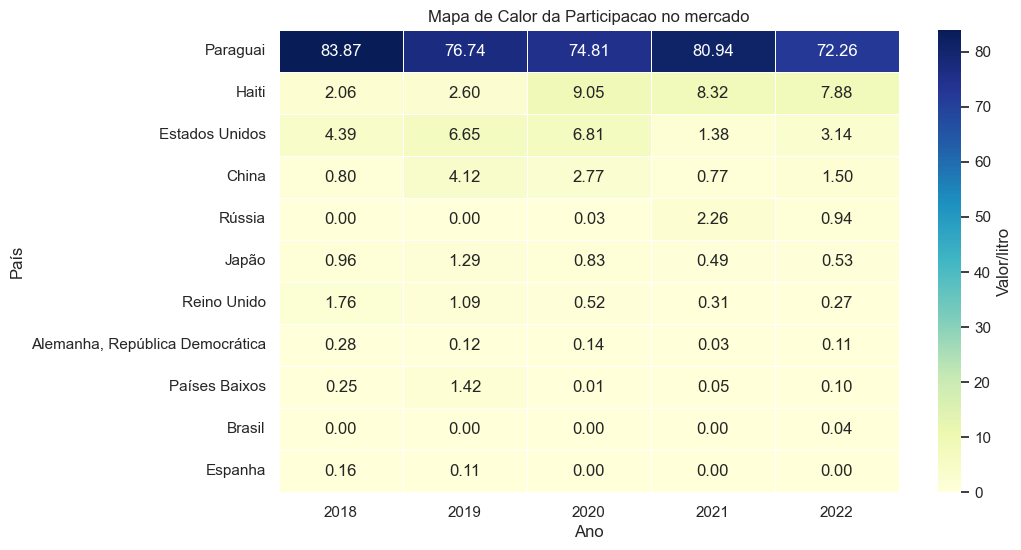

In [11]:
# Criando uma Pivot Table para identificar a tendencia de crescimento no mercado de cada país
df_exp_proporcao_top10 = df_exp_top10_mais_brasil.pivot(index = 'País', columns= 'Ano', values='Proporção (%)')

# Criando dataframe considerando apenas os últimos 5 anos
df_mapadecalor_proporcao = df_exp_proporcao_top10[df_exp_proporcao_top10.columns[10:]].sort_values(2022, ascending = False)


# Criando mapa de calor p/ Proporcao de mercado dos últimos 5 anos top10 países com mais exportação em volume + Brasil

# Ajustando o tamanho da figura
plt.figure(figsize=(10, 6))

# Criando o heatmap
sns.heatmap(df_mapadecalor_proporcao, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Valor/litro'})

# Adicionando título e rótulos aos eixos
plt.title('Mapa de Calor da Participacao no mercado')
plt.xlabel('Ano')
plt.ylabel('País')

# Exibindo o gráfico
plt.show()


In [14]:
# Filtrando apenas os últimos 5 anos dos dados de Exportacao
df_exp_vinhos_final_ultimos_cinco_anos = df_exp_vinhos_final.query('Ano >= 2017')
df_exp_vinhos_final_ultimos_cinco_anos.groupby('País')[['Quantidade_kg', 'Valor_us']].mean(numeric_only=True)

#Ordenando por Pais e ano para facilitar a visualizacao
df_exp_vinhos_final_ultimos_cinco_anos = df_exp_vinhos_final_ultimos_cinco_anos.sort_values(['País', 'Ano'], ascending=True).reset_index()

#Funcao para calcular a taxa de crescimento da exportacao ano após ano
def calcular_taxa_crescimento(valor_inicial, valor_final):
    if valor_inicial != 0:
        return ((valor_final - valor_inicial) / valor_inicial) * 100
    elif valor_final != 0:
        return 0
    else:
        return 0

resultado = []

#Calculando a taxa para cada valor de Quantidade para cada País, a cada ano
for index, row in df_exp_vinhos_final_ultimos_cinco_anos.iterrows():
    if index > 0:
        valor_inicial = df_exp_vinhos_final_ultimos_cinco_anos.loc[index - 1, 'Quantidade_kg'] if df_exp_vinhos_final_ultimos_cinco_anos.loc[index - 1, 'País'] == row['País'] else 0
        taxa_crescimento = calcular_taxa_crescimento(valor_inicial, row['Quantidade_kg'])
        resultado.append(taxa_crescimento)
    else:
        resultado.append(0)  # A taxa de crescimento para o primeiro ano pode ser considerada 0

# Criando uma coluna com os resultados de taxa
df_exp_vinhos_final_ultimos_cinco_anos['Taxa de Crescimento'] = resultado


,index,Id,País,Ano,Quantidade_kg,Valor_us,Taxa de Crescimento
0,6016,1,Afeganistão,2017,0,0,0.00
1,6144,1,Afeganistão,2018,0,0,0.00
2,6272,1,Afeganistão,2019,0,0,0.00
3,6400,1,Afeganistão,2020,0,0,0.00
4,6528,1,Afeganistão,2021,11,46,0.00
...,...,...,...,...,...,...,...
763,6154,11,Áustria,2018,0,0,0.00
764,6282,11,Áustria,2019,0,0,0.00
765,6410,11,Áustria,2020,0,0,0.00
766,6538,11,Áustria,2021,0,0,0.00


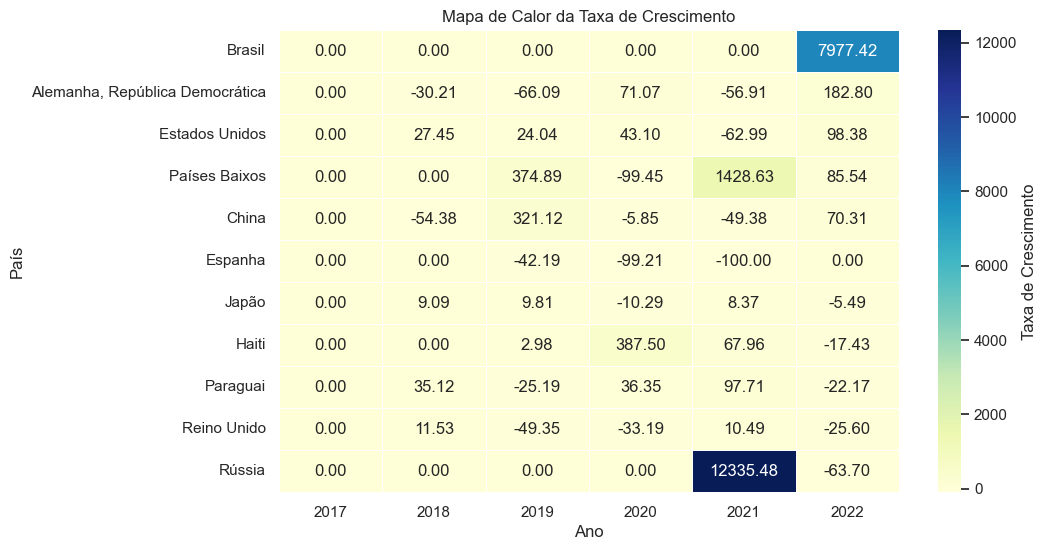

In [16]:
# Criando uma Pivot Table para identificar a taxa de crescimento de exportacao
df_pivot_exp_taxa_crescimento = df_exp_vinhos_final_ultimos_cinco_anos.pivot(index = 'País', columns= 'Ano', values='Taxa de Crescimento').sort_values(2022, ascending = False)

#Selecionando os TOP10 países
df_pivot_exp_taxa_crescimento = df_pivot_exp_taxa_crescimento.query('País in @lista_top10_exportadores')

# Criando mapa de calor p/ Taxa de Crescimento de exportacao dos últimos 5 anos top10 países com mais exportação em volume + Brasil
# Ajustando o tamanho da figura
plt.figure(figsize=(10, 6))

# Criando o heatmap
sns.heatmap(df_pivot_exp_taxa_crescimento, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Taxa de Crescimento'})

# Adicionando título e rótulos aos eixos
plt.title('Mapa de Calor da Taxa de Crescimento')
plt.xlabel('Ano')
plt.ylabel('País')

# Exibindo o gráfico
plt.show()

### Comércio

In [17]:
df_comercio = pd.read_csv(f"{path_dados_vinho}Comercio.csv", sep=";", header=None)

# Mantendo apenas as colunas ID, Categoria, Subcategoria para os últimos 15 anos.
df_comercio.columns = ['ID', 'Categoria', 'Subcategoria'] + [str(ano) for ano in range(1970, 2022)]

# Função para tratar as categorias
def categorizar(cat):
    mappings = {
        'vm': 'VINHO DE MESA',
        've': 'VINHO ESPECIAL',
        'es': 'ESPUMANTES',
        'su': 'SUCO DE UVAS',
        'ou': 'OUTROS PRODUTOS COMERCIALIZADOS'
    }
    prefixo = cat.split('_')[0]  # Obtém apenas o prefixo (primeira parte antes do "_")
    return mappings.get(prefixo, prefixo)  # Retorna o valor mapeado, ou o prefixo original se não estiver no mapeamento

df_comercio['Categoria'] = df_comercio['Categoria'].apply(categorizar)

# Filtrando apenas os dados de comércio de vinhos por categoria
df_comercio_vinhos = df_comercio.query("(Categoria == Subcategoria & Categoria.str.contains('VINHO')) | Categoria == 'OUTROS PRODUTOS COMERCIALIZADOS' & Subcategoria.str.contains('Vinho')")

# Filtrando apenas os últimos 15 anos
filtro_ultimos_quinze_anos = ['ID', 'Categoria', 'Subcategoria'] + [str(ano) for ano in range(2008, 2022)]
df_comercio_vinhos_ultimos_quinze_anos = df_comercio_vinhos[filtro_ultimos_quinze_anos]

# Realizando o melt para transformar a coluna anos em linhas
df_comercio_vinhos_melted = df_comercio_vinhos_ultimos_quinze_anos.melt(id_vars=['ID', 'Categoria', 'Subcategoria'], 
                                            var_name='Ano', 
                                            value_name='Valor')

# Organizando o DataFrame para uma melhor visualização
df_comercio_vinhos_melted.sort_values(by=['ID', 'Ano'], inplace=True)
df_comercio_vinhos_melted.reset_index(drop=True, inplace=True)


In [18]:
#Separando os vinhos com categoria diferente de Vinho de Mesa

df_comercio_outros = df_comercio_vinhos_melted.query('Categoria != "VINHO DE MESA"')
df_comercio_outros_ano = df_comercio_outros.groupby('Ano')['Valor'].sum().reset_index()
df_comercio_outros_ano['Categoria'] = 'Soma dos Outros'

In [19]:
#Concatenando com o DataFrame que contem os dados de Vinho de Mesa
df_comercio_vinhos_categoria = df_comercio_vinhos_melted.drop(columns = ['Subcategoria', 'ID'])
df_comercio_vinhos_categoria = pd.concat([df_comercio_vinhos_categoria.query('Categoria == "VINHO DE MESA"'), df_comercio_outros_ano])


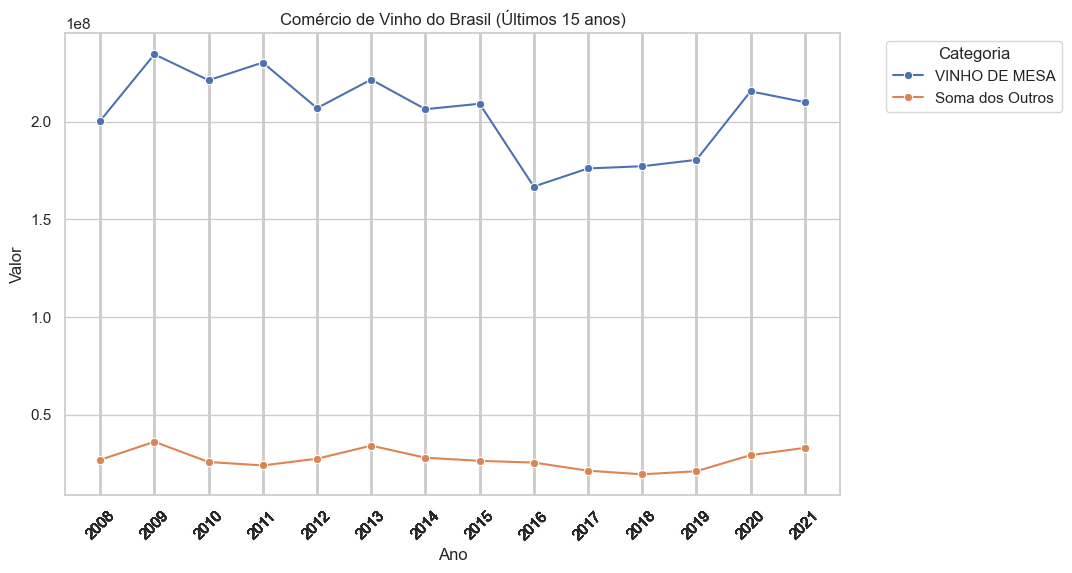

In [20]:
#Plotando o gráfico de Comercializacao por Categoria
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_comercio_vinhos_categoria, x='Ano', y='Valor', hue='Categoria', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Comércio de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_comercio_vinhos_melted['Ano'], labels=df_comercio_vinhos_melted['Ano'])

plt.show()

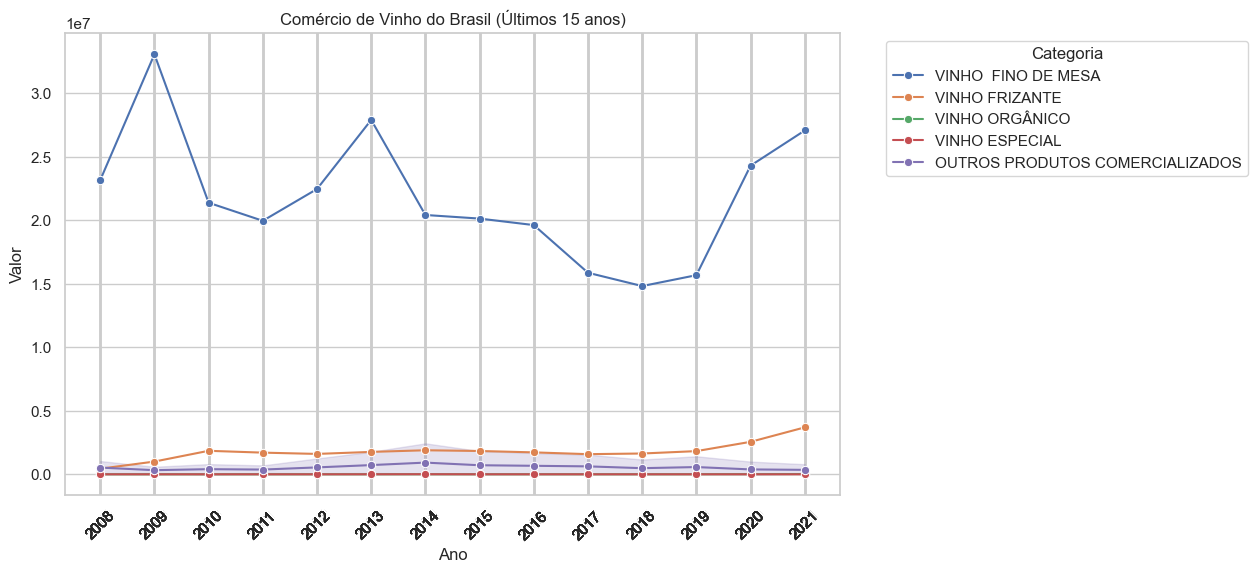

In [21]:
# Abrindo os vinhos categorizados como 'Soma dos Outros', temos:

# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_comercio_outros, x='Ano', y='Valor', hue='Categoria', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Comércio de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_comercio_vinhos_melted['Ano'], labels=df_comercio_vinhos_melted['Ano'])

plt.show()

### Importação

In [22]:
df_imp_espumantes = pd.read_csv(f"{path_dados_vinho}ImpEspumantes.csv", sep=";")
df_imp_frescas = pd.read_csv(f"{path_dados_vinho}ImpFrescas.csv", sep=";")
df_imp_passas = pd.read_csv(f"{path_dados_vinho}ImpPassas.csv", sep=";")
df_imp_suco = pd.read_csv(f"{path_dados_vinho}ImpSuco.csv", sep=";")
df_imp_vinhos = pd.read_csv(f"{path_dados_vinho}ImpVinhos.csv", sep=";")

# Derretendo o DataFrame de Importação de Vinhos para ter uma linha para cada ano
df_imp_vinhos_melted = pd.melt(df_imp_vinhos, id_vars=['Id', 'País'], var_name='Ano_Metrica', value_name='Valor')

# Separando o Ano e a Métrica (Quantidade_kg ou Valor_Us) em colunas separadas
df_imp_vinhos_melted[['Ano', 'Metrica']] = df_imp_vinhos_melted['Ano_Metrica'].str.extract('(\d+)(\.\d+)?')

# Criando um DataFrame separado para Quantidade_kg e Valor_Us
df_quantidade_imp = df_imp_vinhos_melted[df_imp_vinhos_melted['Metrica'].isna()].drop(columns='Metrica').rename(columns={'Valor': 'Quantidade_kg'})
df_valor_imp = df_imp_vinhos_melted[df_imp_vinhos_melted['Metrica'].notna()].drop(columns='Metrica').rename(columns={'Valor': 'Valor_us'})

# Mesclando os DataFrames de Quantidade_kg e Valor_Us com base no Id, País e Ano
df_imp_vinhos_final = pd.merge(df_quantidade_imp, df_valor_imp, on=['Id', 'País', 'Ano'])

# Reordenando/Renomeando as colunas
df_imp_vinhos_final = df_imp_vinhos_final[['Id', 'País', 'Ano', 'Quantidade_kg', 'Valor_us']]

# Filtrando apenas os últimos 15 anos
df_imp_vinhos_final['Ano'] = df_imp_vinhos_final['Ano'].astype(int)
df_imp_vinhos_final_ultimos_quinze_anos = df_imp_vinhos_final.query('Ano >= 2008')
df_imp_vinhos_final_ultimos_quinze_anos.rename(columns={'Quantidade_kg':'Quantidade_l'}, inplace=True)

# Função para identificar os 10 principais países por métrica
def filter_top_10(df, metric):
    top_10_countries = df.groupby('País')[metric].sum().nlargest(10, 'all').index
    return df[df['País'].isin(top_10_countries)]

# Filtrando para os 10 principais países para cada métrica
df_top_10_quantidade_imp = filter_top_10(df_imp_vinhos_final_ultimos_quinze_anos, 'Quantidade_l')
df_top_10_valor_imp = filter_top_10(df_imp_vinhos_final_ultimos_quinze_anos, 'Valor_us')


C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\2627766007.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp_vinhos_final_ultimos_quinze_anos.rename(columns={'Quantidade_kg':'Quantidade_l'}, inplace=True)


C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\1663304924.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_top_10_quantidade_imp, x='País', y='Quantidade_l', ci=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


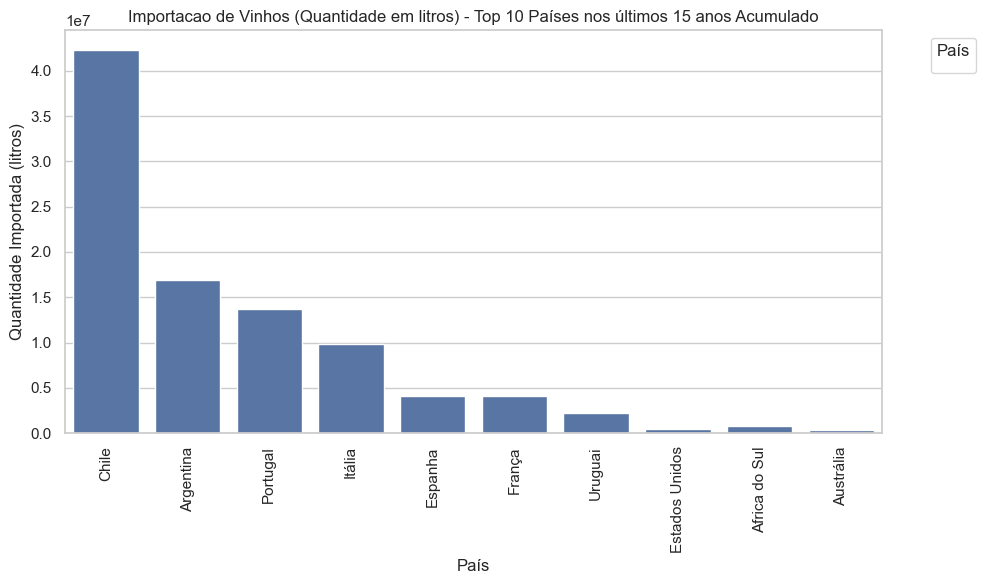

In [45]:
#Plotando um gráfico de barras com os maiores importadores de vinho do mundo

df_top_10_quantidade_imp = df_top_10_quantidade_imp.sort_values('Quantidade_l', ascending=False)

sns.set_theme(style="whitegrid")

# Criando o gráfico para Quantidade_kg
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_10_quantidade_imp, x='País', y='Quantidade_l', ci=None)
plt.title('Importacao de Vinhos (Quantidade em litros) - Top 10 Países nos últimos 15 anos Acumulado')
plt.xlabel('País')
plt.ylabel('Quantidade Importada (litros)')
plt.xticks(rotation=90)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Processamento

In [25]:
df_proc_americanas = pd.read_csv(f"{path_dados_vinho}ProcessaAmericanas.csv", sep=";")
df_proc_mesa = pd.read_csv(f"{path_dados_vinho}ProcessaMesa.csv", sep=";")
df_proc_viniferas = pd.read_csv(f"{path_dados_vinho}ProcessaViniferas.csv", sep="\t")

# Filtrando dos dados de processamento apenas os valores absolutos por categoria de  vinhos
df_proc_viniferas_categorias = df_proc_viniferas.query('(cultivar == "TINTAS") | (cultivar == "BRANCAS E ROSADAS")').head()

# Dropando coluna redundante "control"
df_proc_viniferas_categorias.drop(columns = 'control', axis=1, inplace=True)

# Derretendo o dataframe para transformar anos em linhas
df_proc_viniferas_categorias_melted = pd.melt(df_proc_viniferas_categorias, id_vars=['id', 'cultivar'], var_name = 'Ano', value_name = 'Quantidade_litros')

# Transformando a coluna Ano em int para filtrar os últimso 15 anos
df_proc_viniferas_categorias_melted.Ano = df_proc_viniferas_categorias_melted.Ano.astype(int)
df_proc_viniferas_categorias_ultimos_quinze_anos = df_proc_viniferas_categorias_melted.query('Ano >= 2008')

# Tratando valores nulos
df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'] = df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'].replace('nd', '0')

# Transformando a coluna de volta para inteiro
df_proc_viniferas_categorias_ultimos_quinze_anos.Quantidade_litros = df_proc_viniferas_categorias_ultimos_quinze_anos.Quantidade_litros.astype(int)

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\2065456112.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'] = df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'].replace('nd', '0')
C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\2065456112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc_viniferas_categorias_ultimos_quinze_anos.Quantidade_litros = df_proc_viniferas_categorias_ultimos

### Produção

In [26]:
df_produção = pd.read_csv(f"{path_dados_vinho}Producao.csv", sep=";")

# Filtrando dos dados de producao apenas Vinhos
df_producao_vinhos = df_produção.query("produto.str.contains('VINHO') | produto.str.contains('Vinho')" )

# Derretendo o dataframe para considerar as colunas de Ano como Linhas
df_producao_vinhos = df_producao_vinhosmelted = pd.melt(df_producao_vinhos, id_vars=['id', 'produto'], var_name='Ano', value_name='Quantidade_litros')

# Modificando o type da coluna Ano para inteiro para filtrar os últimos 15 anos
df_producao_vinhos.Ano = df_producao_vinhos.Ano.astype('int')
df_producao_vinhos_ultimos_quinze_anos = df_producao_vinhos.query('Ano >= 2008')


In [27]:
df_producao_vinhos_ultimos_quinze_anos.groupby('produto')['Quantidade_litros'].sum()

produto
VINHO DE MESA                    2959668283
VINHO FINO DE MESA (VINÍFERA)     588670427
Vinho Composto                       163000
Vinho acidificado                     65000
Vinho leve                             8000
Vinho licoroso                       677236
Vinho orgânico                       222074
Name: Quantidade_litros, dtype: int64

In [28]:
df_producao_outros = df_producao_vinhos_ultimos_quinze_anos.query('produto != "VINHO DE MESA"')
df_producao_outros = df_producao_outros.groupby('Ano')['Quantidade_litros'].sum().reset_index()
df_producao_outros['produto'] = 'Soma dos outros'
df_producao_outros

,Ano,Quantidade_litros,produto
0,2008,47415151,Soma dos outros
1,2009,39900568,Soma dos outros
2,2010,24820713,Soma dos outros
3,2011,47604071,Soma dos outros
4,2012,45200730,Soma dos outros
5,2013,45782630,Soma dos outros
6,2014,38503314,Soma dos outros
7,2015,37204982,Soma dos outros
8,2016,18094826,Soma dos outros
9,2017,44648690,Soma dos outros


In [29]:
df_producao_vinhos_ultimos_quinze_anos = df_producao_vinhos_ultimos_quinze_anos.drop('id', axis=1)
df_producao_vinhos_categoria = pd.concat([df_producao_vinhos_ultimos_quinze_anos.query('produto == "VINHO DE MESA"'), df_producao_outros])
df_producao_vinhos_categoria


,produto,Ano,Quantidade_litros
266,VINHO DE MESA,2008,287506811
273,VINHO DE MESA,2009,205418206
280,VINHO DE MESA,2010,195267980
287,VINHO DE MESA,2011,257840749
294,VINHO DE MESA,2012,212777037
301,VINHO DE MESA,2013,196904222
308,VINHO DE MESA,2014,196173123
315,VINHO DE MESA,2015,210308560
322,VINHO DE MESA,2016,86319015
329,VINHO DE MESA,2017,255015187


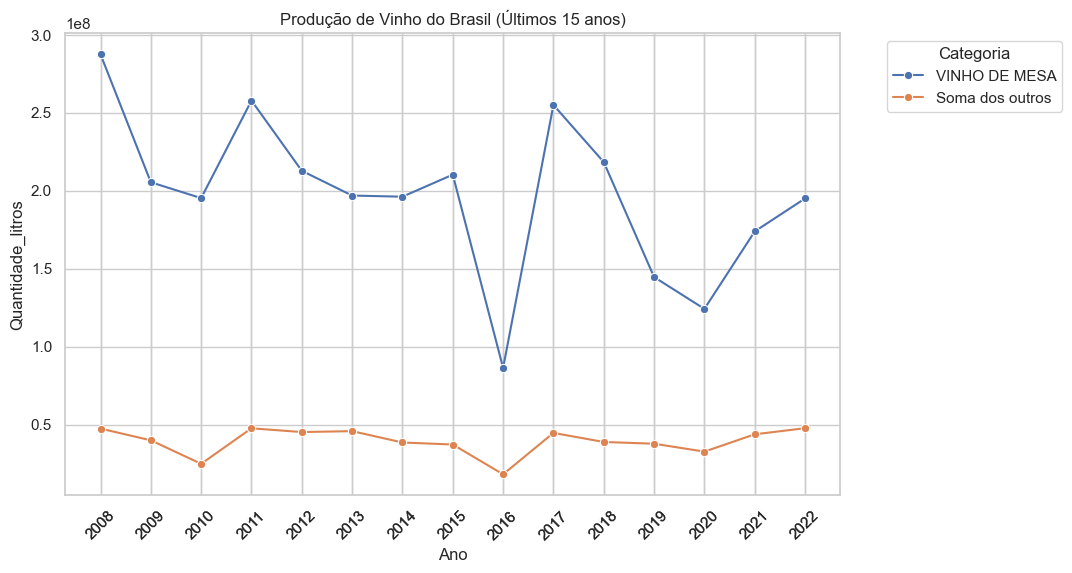

In [30]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_producao_vinhos_categoria, x='Ano', y='Quantidade_litros', hue='produto', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Produção de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Quantidade_litros')
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_producao_vinhos_categoria['Ano'], labels=df_producao_vinhos_categoria['Ano'])

plt.show()

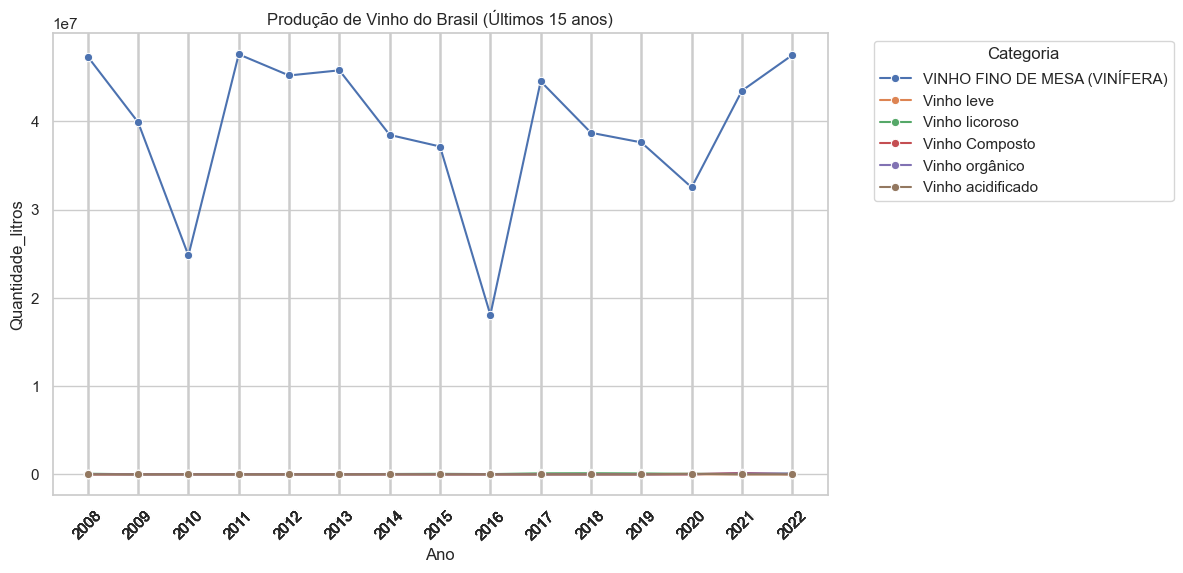

In [31]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_producao_vinhos_ultimos_quinze_anos.query('produto != "VINHO DE MESA"'), x='Ano', y='Quantidade_litros', hue='produto', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Produção de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Quantidade_litros')
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_producao_vinhos_ultimos_quinze_anos.query('produto != "VINHO DE MESA"')['Ano'], labels=df_producao_vinhos_ultimos_quinze_anos.query('produto != "VINHO DE MESA"')['Ano'])

plt.show()

### Temperatura

In [32]:
FILE_ID = '1-hO1qJ3e90VCRy-u67F-u_wT4lKuym2j'
filename = 'city_temperature.csv'
output = os.path.join(path_dados_genericos, filename)

if not os.path.exists(output):
    url = f'https://drive.google.com/uc?id={FILE_ID}'
    gdown.download(url, output, quiet=False)
else:
    print("O arquivo já existe.")

df_temperaturas = pd.read_csv(f"{path_dados_genericos}city_temperature.csv", sep=",", low_memory=False)
df_temperaturas = df_temperaturas[['Country', 'Year', 'AvgTemperature']]
df_temperaturas = df_temperaturas.groupby(['Country', 'Year'], as_index=False).agg({'AvgTemperature': 'mean'})

O arquivo já existe.


### Expectativa de vida

In [33]:
df_expectativa_vida = pd.read_csv(f"{path_dados_genericos}life_expectancy_data.csv", sep=",")

## Construção das tabelas

### Exportação

In [34]:
df_exp_espumantes_melted = df_exp_espumantes.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_espumantes_melted["categoria"] = "Bebida"
df_exp_espumantes_melted["subcategoria"] = "Espumante"

df_exp_suco_melted = df_exp_suco.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_suco_melted["categoria"] = "Bebida"
df_exp_suco_melted["subcategoria"] = "Suco"

df_exp_uva_melted = df_exp_uva.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_uva_melted["categoria"] = "Fruta"
df_exp_uva_melted["subcategoria"] = "Uva"

df_exp_vinho_melted = df_exp_vinho.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_vinho_melted["categoria"] = "Bebida"
df_exp_vinho_melted["subcategoria"] = "Vinho"

df_exportacao_total = pd.concat([df_exp_espumantes_melted, df_exp_suco_melted, df_exp_uva_melted, df_exp_vinho_melted], ignore_index=True)

df_exportacao_total['ano'] = df_exportacao_total['ano'].astype(str)

df_exportacao_total['ano'] = df_exportacao_total['ano'].str.split('.').str[0]

df_exportacao_total['ano'] = df_exportacao_total['ano'].astype(int)

## Visualização de Dados

### Evolução da Importação de vinhos dos top 10 países últimos 15 anos

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\3199335910.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_valor_imp['Ano'] = df_top_10_valor_imp['Ano'].astype(str)


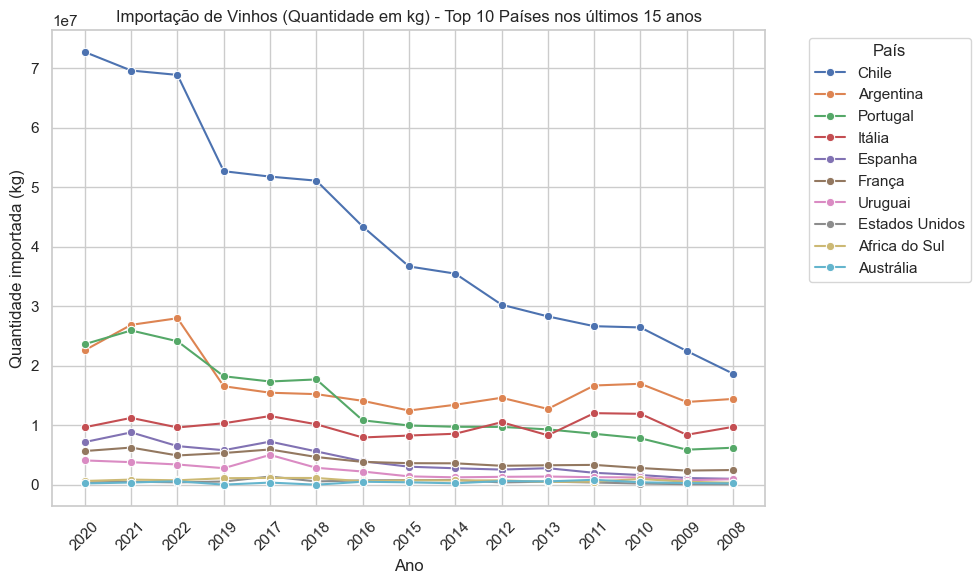

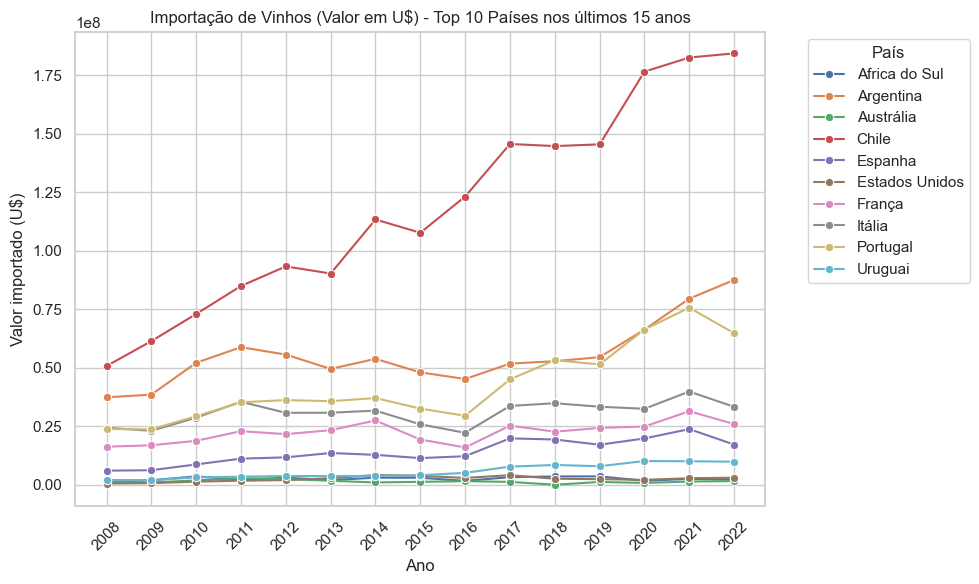

In [46]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Mudando o type da coluna Ano para STR para aparecer todos os ticks
df_top_10_quantidade_imp['Ano'] = df_top_10_quantidade_imp['Ano'].astype(str)
df_top_10_valor_imp['Ano'] = df_top_10_valor_imp['Ano'].astype(str)

# Criando o gráfico para Quantidade_kg
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top_10_quantidade_imp, x='Ano', y='Quantidade_l', hue='País', marker="o")
plt.title('Importação de Vinhos (Quantidade em kg) - Top 10 Países nos últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade importada (kg)')
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Evolução da Exportação de vinhos dos top 10 países dos últimos 15 anos

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\1356709900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_quantidade_exp['Ano'] = df_top_10_quantidade_exp['Ano'].astype(str)
C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49932\1356709900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_valor_exp['Ano'] = df_top_10_valor_exp['Ano'].astype(str)


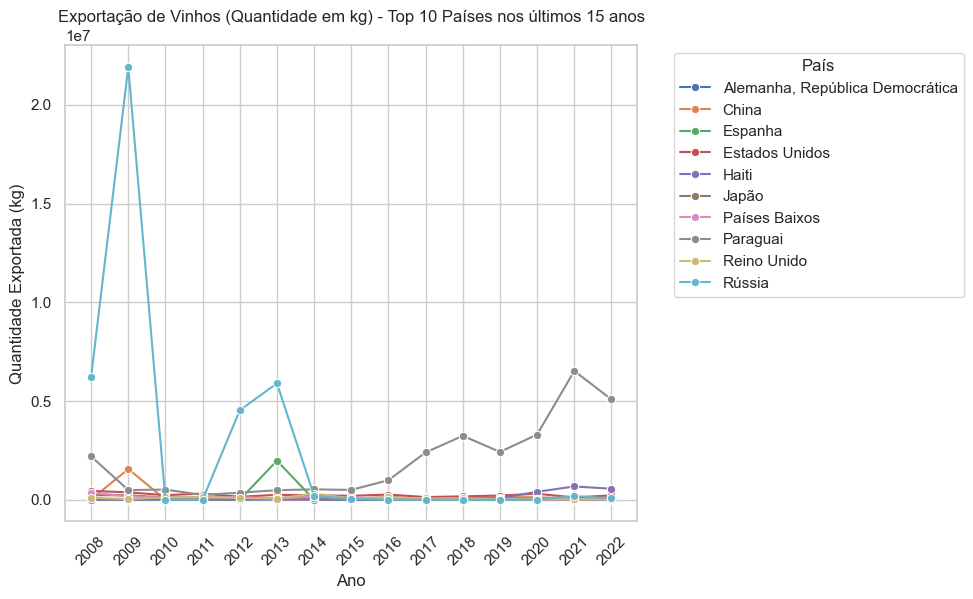

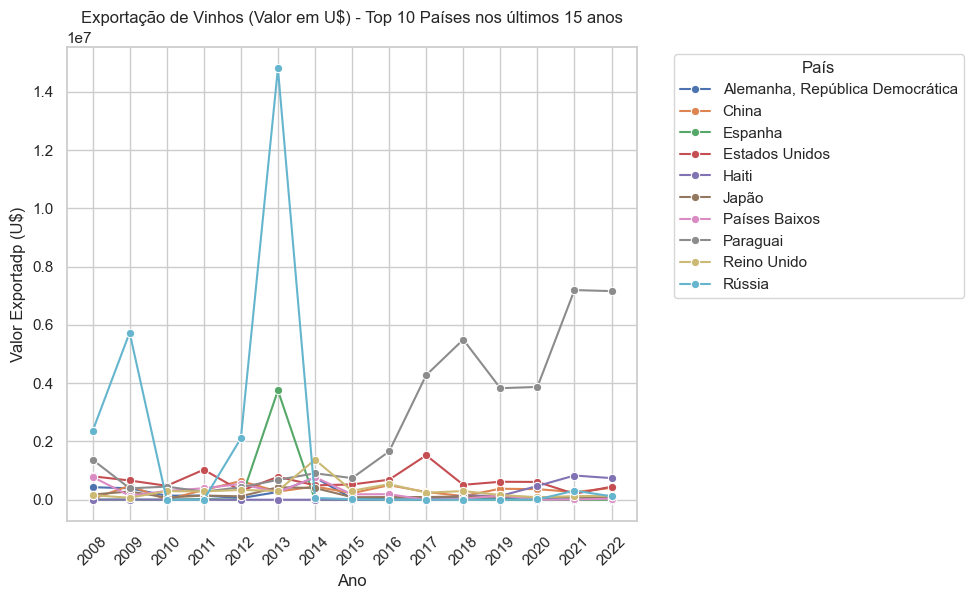

In [36]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Mudando o type da coluna Ano para STR para aparecer todos os ticks
df_top_10_quantidade_exp['Ano'] = df_top_10_quantidade_exp['Ano'].astype(str)
df_top_10_valor_exp['Ano'] = df_top_10_valor_exp['Ano'].astype(str)

# Criando o gráfico para Quantidade_kg
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top_10_quantidade_exp, x='Ano', y='Quantidade_kg', hue='País', marker="o")
plt.title('Exportação de Vinhos (Quantidade em kg) - Top 10 Países nos últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade Exportada (kg)')
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Evolução no Processamento de vinhos últimos 15 anos

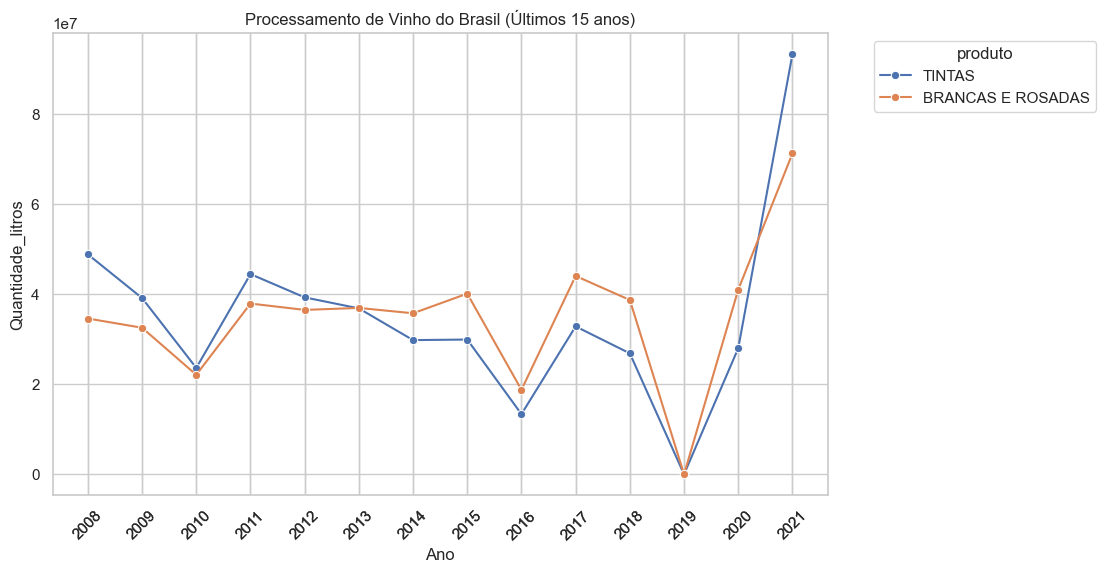

In [38]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Mudando o type da coluna Ano para STR
df_proc_viniferas_categorias_ultimos_quinze_anos.Ano.astype(str)

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_proc_viniferas_categorias_ultimos_quinze_anos, x='Ano', y='Quantidade_litros', hue='cultivar', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Processamento de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Quantidade_litros')
plt.xticks(rotation=45)
plt.legend(title='produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_proc_viniferas_categorias_ultimos_quinze_anos['Ano'], labels=df_proc_viniferas_categorias_ultimos_quinze_anos['Ano'])

plt.show()

### Exportação

In [39]:
df_ultimos_15_anos = df_exportacao_total[df_exportacao_total['ano'] >= 2007]

#### Evolução das Exportações ao Longo do Tempo:
Este gráfico de linhas mostra como as exportações totais mudaram ano a ano nos últimos 15 anos. Cada ponto na linha representa o valor total exportado em um ano específico, e a linha conecta esses pontos para mostrar a tendência ao longo do tempo. Este gráfico ajuda a identificar padrões ou anomalias nas exportações ao longo dos anos e pode ser útil para entender se existe uma tendência de crescimento, declínio ou estabilidade nas exportações.

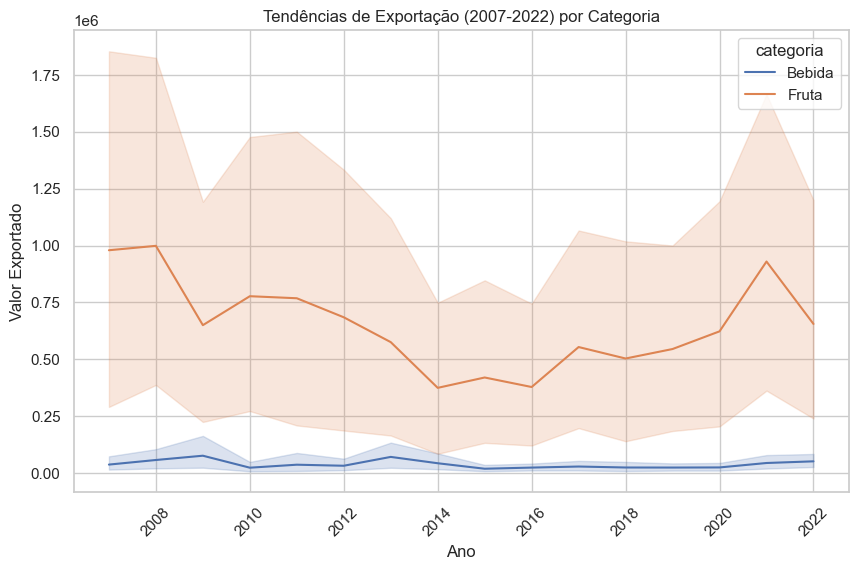

In [40]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_ultimos_15_anos, x="ano", y="valor", hue="categoria")
plt.title('Tendências de Exportação (2007-2022) por Categoria')
plt.ylabel('Valor Exportado')
plt.xlabel('Ano')
plt.xticks(rotation=45)
plt.show()


#### Distribuição de Exportações por País Destino (2007-2022) - Top 10 Países
Este gráfico de barras exibe os dez países para os quais o Brasil mais exportou nos últimos 15 anos. O eixo X mostra os países, e o eixo Y mostra o valor total exportado para cada país. As barras são proporcionais aos valores exportados. Este gráfico é útil para identificar os principais destinos das exportações brasileiras e entender quais países têm a maior participação no mercado de exportação.

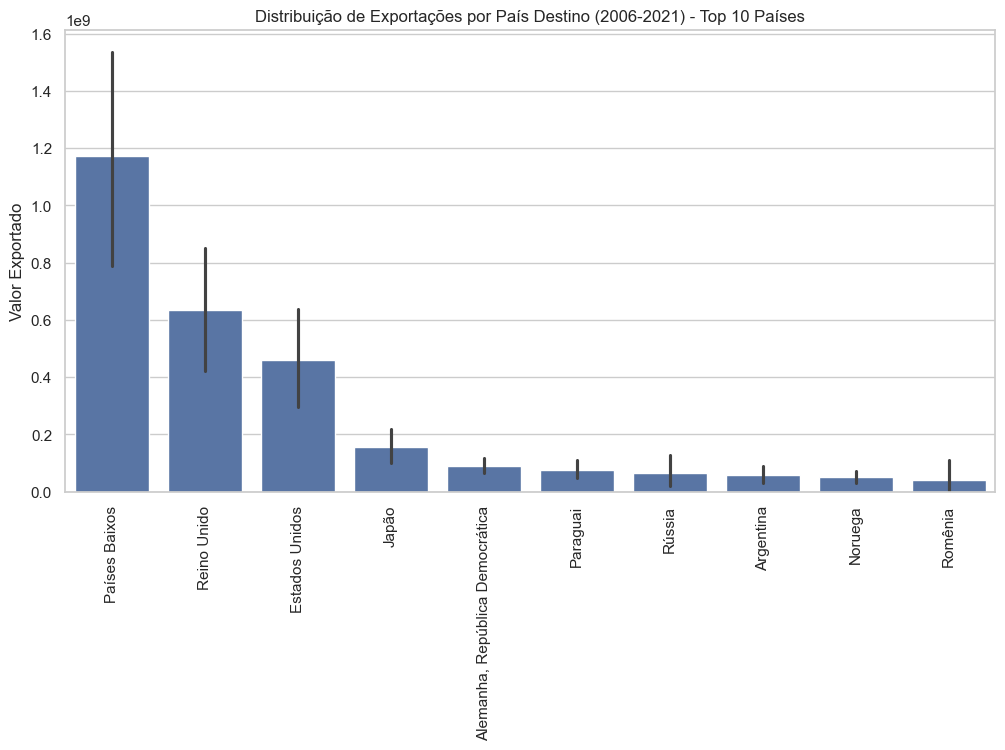

In [41]:
df_soma_por_pais = df_ultimos_15_anos.groupby('País')['valor'].sum().reset_index()

top_10_paises = df_soma_por_pais.sort_values(by='valor', ascending=False).head(10)

df_top_10_paises = df_ultimos_15_anos[df_ultimos_15_anos['País'].isin(top_10_paises['País'])]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_10_paises, x="País", y="valor", estimator=sum, order=top_10_paises['País'])
plt.title('Distribuição de Exportações por País Destino (2006-2021) - Top 10 Países')
plt.ylabel('Valor Exportado')
plt.xlabel('')
plt.xticks(rotation=90)
plt.show()


#### Proporção de Exportações por Categoria de Produto (2007-2022):
Este gráfico de pizza mostra a proporção do valor total exportado atribuída a cada categoria de produto nos últimos 15 anos. Cada fatia da pizza representa uma categoria de produto, e o tamanho da fatia é proporcional ao valor total exportado para essa categoria. As porcentagens em cada fatia indicam a participação de cada categoria no total de exportações. Este gráfico ajuda a visualizar rapidamente quais categorias são mais significativas em termos de valor exportado.

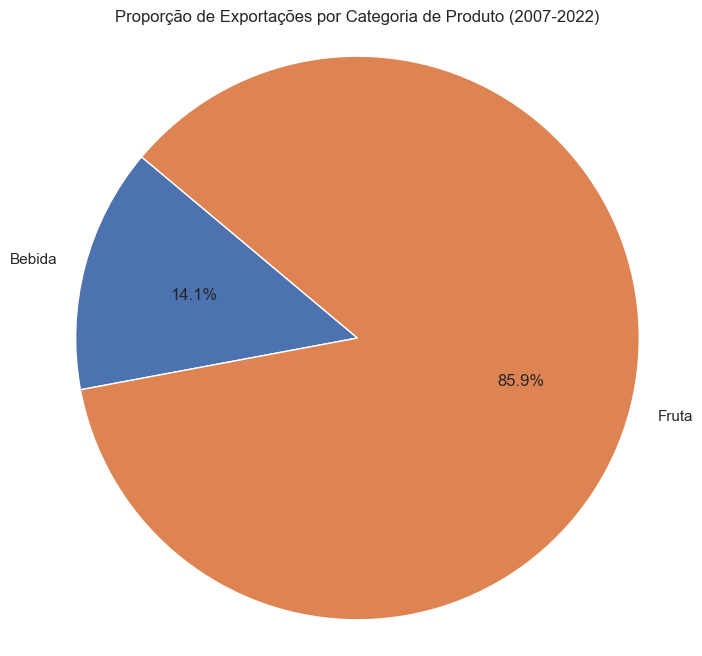

In [42]:
df_soma_por_categoria = df_ultimos_15_anos.groupby('categoria')['valor'].sum()

plt.figure(figsize=(8, 8))
plt.pie(df_soma_por_categoria, labels=df_soma_por_categoria.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Proporção de Exportações por Categoria de Produto (2007-2022)')
plt.show()

#### Correlação entre Anos e Valores Exportados:
Este mapa de calor mostra a correlação entre diferentes variáveis no dataframe. Cada célula no mapa de calor representa a correlação entre duas variáveis, e a cor da célula indica a força e a direção da correlação (cores mais quentes indicam correlação positiva, cores mais frias indicam correlação negativa). Este gráfico é útil para identificar relações entre diferentes variáveis e pode ajudar a entender quais fatores estão mais fortemente associados a valores de exportação mais altos ou mais baixos.

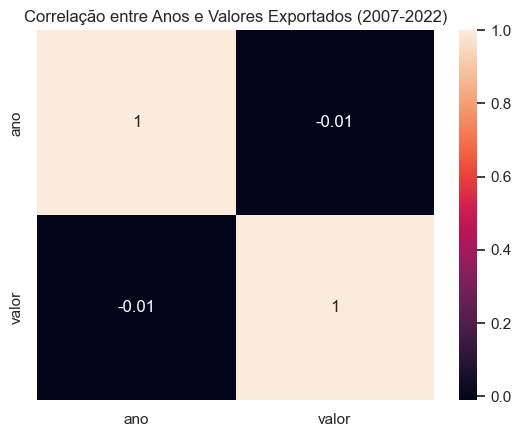

In [43]:
corr_matrix = df_ultimos_15_anos[['ano', 'valor']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlação entre Anos e Valores Exportados (2007-2022)')
plt.show()

Análise Estatística Descritiva:

In [44]:
desc_stats = df_ultimos_15_anos['valor'].describe()
print(desc_stats)

count      15264.00
mean      201703.24
std      2304412.52
min            0.00
25%            0.00
50%            0.00
75%          150.00
max     80976901.00
Name: valor, dtype: float64
